# Narrow transformation
* In Narrow transformation, all the elements that are required to compute the records in single partition live in the single partition of parent RDD. 
* A limited subset of partition is used to calculate the result. 

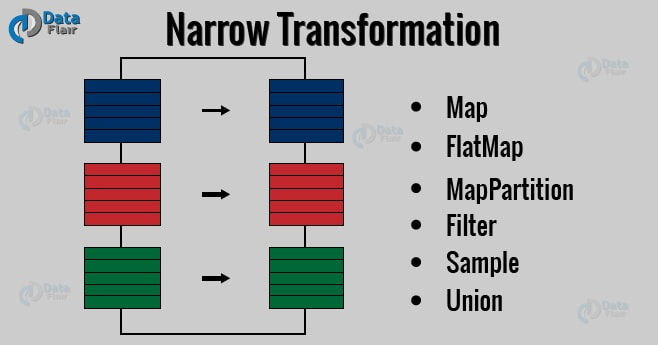

# Wide transformation
* In wide transformation, all the elements that are required to compute the records in the single partition may live in many partitions of parent RDD. 
* The partition may live in many partitions of parent RDD. 

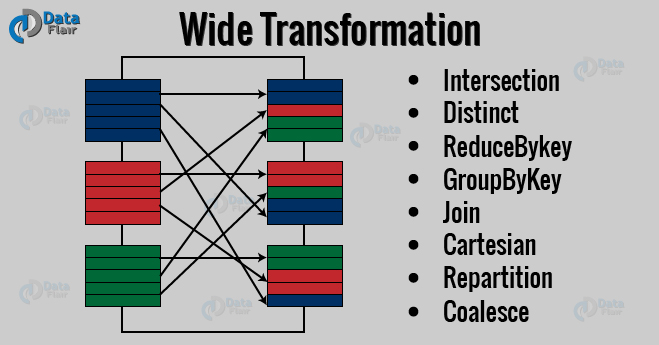

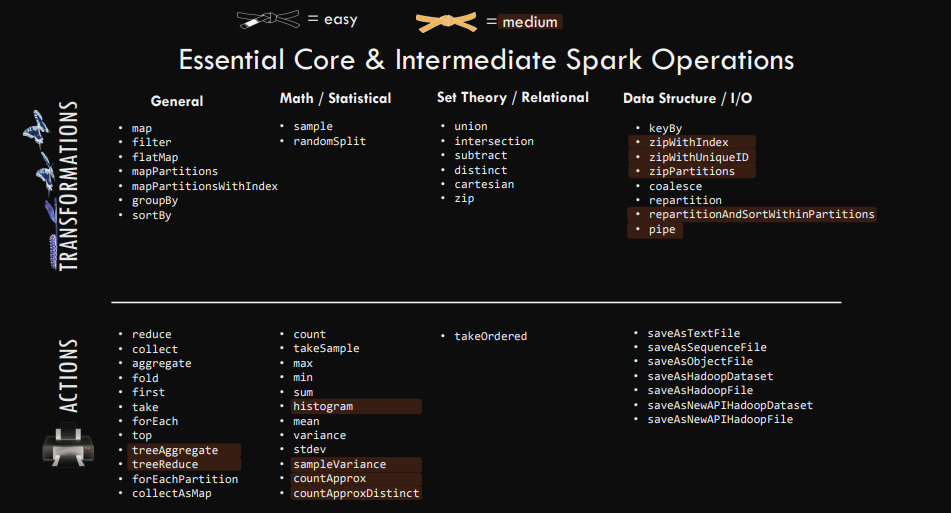
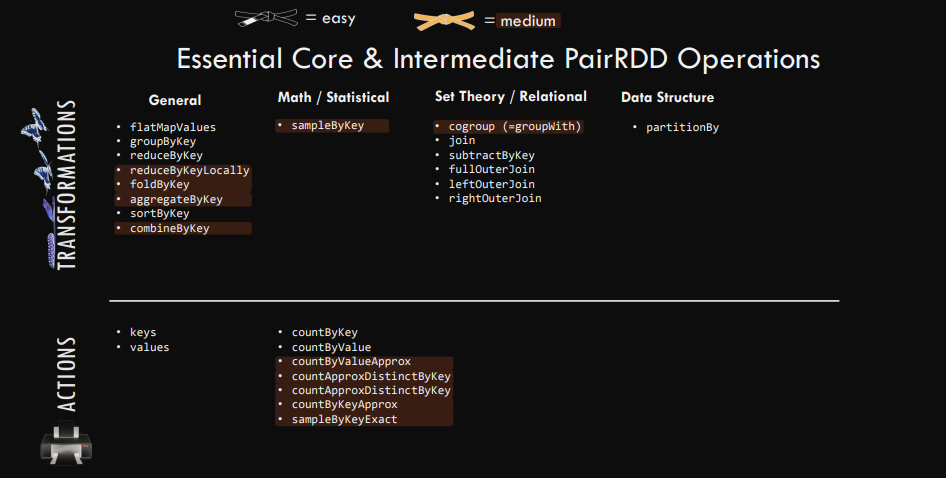

In [1]:
import os

os.environ.get('JAVA_HOME')

'C:\\Program Files\\Java\\jdk1.8.0_311'

In [2]:
import findspark

findspark.init()

In [3]:
from pyspark import SparkContext
import numpy as np

In [4]:
sc = SparkContext(master="local[*]", appName="SparkApp")

# TRANSFORMATION

# Map
Return a new RDD by applying a function to each element of this RDD

In [5]:
x = sc.parallelize(["b", "a", "c"])
y = x.map(lambda z: (z, 1))
print(x.collect())
print(y.collect())

['b', 'a', 'c']
[('b', 1), ('a', 1), ('c', 1)]


# Filter
Return a new RDD containing only the elements that satisfy a predicate

In [6]:
x = sc.parallelize([1, 2, 3])
y = x.filter(lambda x: x % 2 == 1)  #keep odd values
print(x.collect())
print(y.collect())

[1, 2, 3]
[1, 3]


# Flatmap
Return a new RDD by first applying a function to all elements of this RDD, and then flattening the results

In [7]:
x = sc.parallelize([1, 2, 3])
y = x.flatMap(lambda x: (x, x * 100, 42))
print(x.collect())
print(y.collect())

[1, 2, 3]
[1, 100, 42, 2, 200, 42, 3, 300, 42]


# GroupBy
* Group the data in the original RDD. 
* Create pairs where the key is the output of a user function, and the value is all items for which the function yields this key

In [8]:
x = sc.parallelize(['John', 'Fred', 'Anna', 'James'])
y = x.groupBy(lambda w: w[0])
y.collect()

[('J', <pyspark.resultiterable.ResultIterable at 0x20c551b3b80>),
 ('F', <pyspark.resultiterable.ResultIterable at 0x20c551c25e0>),
 ('A', <pyspark.resultiterable.ResultIterable at 0x20c551c2640>)]

In [9]:
for (k, v) in y.collect():
    print(f"{k} => {list(v)}")

J => ['John', 'James']
F => ['Fred']
A => ['Anna']


In [10]:
[(k, list(v)) for (k, v) in y.collect()]

[('J', ['John', 'James']), ('F', ['Fred']), ('A', ['Anna'])]

# GroupByKey
* Group the values for each key in the original RDD. 
* Create a new pair where the original key corresponds to this collected group of values.

groupByKey can cause out of disk problems as data is sent over the network and collected on the reduce workers.

```
sparkContext.textFile("hdfs://")
                    .flatMap(line => line.split(" ") )
                    .map(word => (word,1))
                    .groupByKey()
                    .map((x,y) => (x,sum(y)) )
```

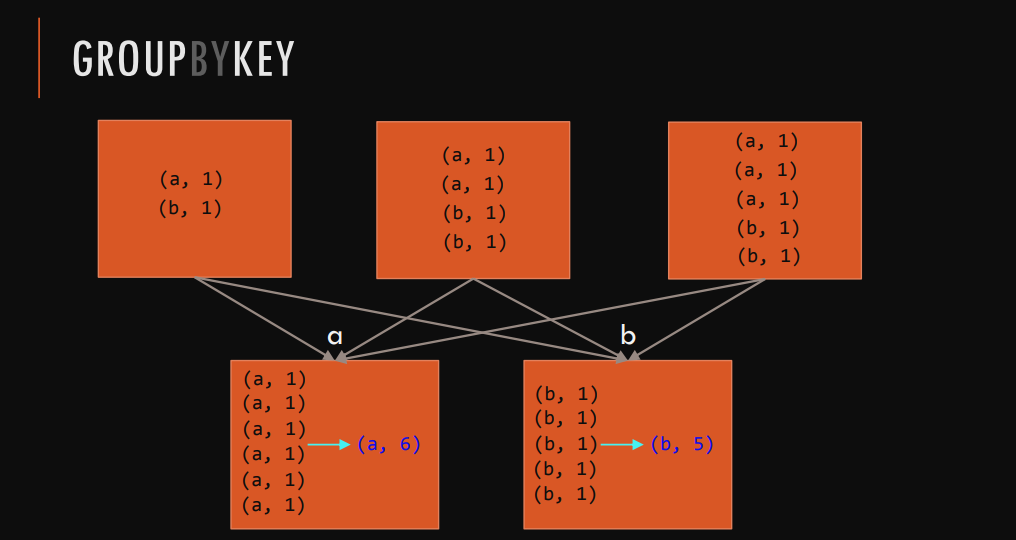

In [11]:
x = sc.parallelize([('B', 5), ('B', 4), ('A', 3), ('A', 2), ('A', 1)])
y = x.groupByKey()
print(x.collect())
print(list((j[0], list(j[1])) for j in y.collect()))

[('B', 5), ('B', 4), ('A', 3), ('A', 2), ('A', 1)]
[('B', [5, 4]), ('A', [3, 2, 1])]


# ReduceByKey

Data is combined at each partition, only one output for one key at each partition to send over the network. reduceByKey required combining all your values into another value with the exact same type.

```
sparkContext.textFile("hdfs://")
                    .flatMap(line => line.split(" "))
                    .map(word => (word,1))
                    .reduceByKey((x,y)=> (x+y))
```

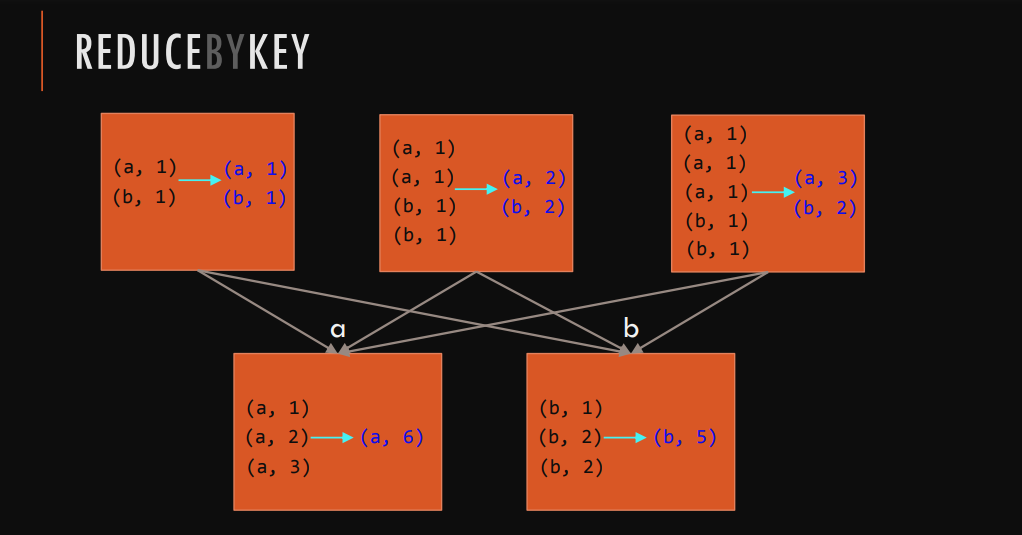

In [12]:
x = sc.parallelize([('B', 5), ('B', 4), ('A', 3), ('A', 2), ('A', 1)])
y = x.reduceByKey(lambda a, b: a + b)
print(x.collect())
print(y.collect())

[('B', 5), ('B', 4), ('A', 3), ('A', 2), ('A', 1)]
[('B', 9), ('A', 6)]


# MapPartitions
Return a new RDD by applying a function to each partition of this RDD

In [20]:
# 2 -> # partitions
x = sc.parallelize([1, 2, 3], 2)

print(x.collect())

# glom() flattens elements on the same partition
print("PARTITIONED DATA:", end=" ")
print(x.glom().collect())

[1, 2, 3]
PARTITIONED DATA: [[1], [2, 3]]


In [22]:
def map_parts(iterator):
    yield sum(iterator)
    yield 42


y = x.mapPartitions(map_parts)
print(y.collect())

# glom() flattens elements on the same partition
print("PARTITIONED DATA:", end=" ")
print(y.glom().collect())

[1, 42, 5, 42]
PARTITIONED DATA: [[1, 42], [5, 42]]


# MapPartitionsWithIndex
Return a new RDD by applying a function to each partition of this RDD,
while tracking the index of the original partition

In [14]:
x = sc.parallelize([1, 2, 3], 2)


def f(partitionIndex, iterator):
    yield (partitionIndex, sum(iterator))


y = x.mapPartitionsWithIndex(f)
# glom() flattens elements on the same partition
print(x.glom().collect())
print(y.glom().collect())

[[1], [2, 3]]
[[(0, 1)], [(1, 5)]]


# Sample
Return a new RDD containing a statistical sample of the original RDD
```
sample(withReplacement, fraction, seed=None)
```

In [15]:
x = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = x.sample(False, 0.4, 42)
print(x.collect())
print(y.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 8, 9, 10]


# Union
Return a new RDD containing all items from two original RDDs. Duplicates are not removed.

In [16]:
x = sc.parallelize([1, 2, 3], 2)
y = sc.parallelize([3, 4], 1)
z = x.union(y)
print(x.glom().collect())
print(y.glom().collect())
print(z.glom().collect())
print(z.collect())

[[1], [2, 3]]
[[3, 4]]
[[1], [2, 3], [3, 4]]
[1, 2, 3, 3, 4]


# Join
Return a new RDD containing all pairs of elements having the same key in the original RDDs

In [17]:
x = sc.parallelize([("a", 1), ("b", 2)])
y = sc.parallelize([("a", 3), ("a", 4), ("b", 5)])
z = x.join(y)
print(z.collect())

[('b', (2, 5)), ('a', (1, 3)), ('a', (1, 4))]


# Distinct
Return a new RDD containing distinct items from the original RDD (omitting all duplicates)

In [23]:
x = sc.parallelize([1, 2, 3, 3, 4])
print(x.glom().collect())
y = x.distinct()
print(y.collect())

[[], [1], [], [2], [3], [], [3], [4]]
[1, 2, 3, 4]


# Coalesce
Return a new RDD which is reduced to a smaller number of partitions

In [19]:
x = sc.parallelize([1, 2, 3, 4, 5], 3)
y = x.coalesce(2)
print(x.glom().collect())
print(y.glom().collect())

[[1], [2, 3], [4, 5]]
[[1], [2, 3, 4, 5]]


# KeyBy
Create a Pair RDD, forming one pair for each item in the original RDD. The
pair’s key is calculated from the value via a user-supplied function.

In [20]:
x = sc.parallelize(['John', 'Fred', 'Anna', 'James'])
y = x.keyBy(lambda w: w[0])
print(y.collect())

[('J', 'John'), ('F', 'Fred'), ('A', 'Anna'), ('J', 'James')]


# PartitionBy
Return a new RDD with the specified number of partitions, placing original 
items into the partition returned by a user supplied function
```
partitionBy(numPartitions, partitioner=portable_hash)
```

In [21]:
x = sc.parallelize([('J', 'James'), ('F', 'Fred'), ('A', 'Anna'),
                    ('J', 'John')], 3)
y = x.partitionBy(2, lambda w: 0 if w[0] < 'H' else 1)
print(x.glom().collect())
print(y.glom().collect())

[[('J', 'James')], [('F', 'Fred')], [('A', 'Anna'), ('J', 'John')]]
[[('F', 'Fred'), ('A', 'Anna')], [('J', 'James'), ('J', 'John')]]


# Zip
Return a new RDD containing pairs whose key is the item in the original RDD, and whose
value is that item’s corresponding element (same partition, same index) in a second RDD

In [22]:
x = sc.parallelize([1, 2, 3])
y = x.map(lambda n: n * n)
z = x.zip(y)
print(z.collect())

[(1, 1), (2, 4), (3, 9)]


# ACTION

# GetNumPartitions
Return the number of partitions in RDD

In [23]:
x = sc.parallelize([1, 2, 3], 2)
y = x.getNumPartitions()
print(x.glom().collect())
print(y)

[[1], [2, 3]]
2


# Collect
Return all items in the RDD to the driver in a single list

In [24]:
x = sc.parallelize([1, 2, 3], 2)
y = x.collect()
print(x.glom().collect())
print(y)

[[1], [2, 3]]
[1, 2, 3]


# Reduce
Aggregate all the elements of the RDD by applying a user function
pairwise to elements and partial results, and returns a result to the driver

In [25]:
x = sc.parallelize([1, 2, 3, 4])
y = x.reduce(lambda a, b: a + b)
print(x.collect())
print(y)

[1, 2, 3, 4]
10


# Aggregate
Aggregate all the elements of the RDD by:
- applying a user function to combine elements with user-supplied objects,
- then combining those user-defined results via a second user function,
- and finally returning a result to the driver.

In [26]:
seqOp = lambda data, item: (data[0] + [item], data[1] + item)
combOp = lambda d1, d2: (d1[0] + d2[0], d1[1] + d2[1])
x = sc.parallelize([1, 2, 3, 4])
y = x.aggregate(([], 0), seqOp, combOp)
print(y)

([1, 2, 3, 4], 10)


# Max
Return the maximum item in the RDD

In [27]:
x = sc.parallelize([2,4,1])
y = x.max()
print(x.collect())
print(y)

[2, 4, 1]
4


# Sum
Return the sum of the items in the RDD

In [28]:
x = sc.parallelize([2,4,1])
y = x.sum()
print(x.collect())
print(y)

[2, 4, 1]
7


# Mean
Return the mean of the items in the RDD

In [29]:
x = sc.parallelize([2,4,1])
y = x.mean()
print(x.collect())
print(y)

[2, 4, 1]
2.3333333333333335


# Stdev
Return the standard deviation of the items in the RDD

In [30]:
x = sc.parallelize([2,4,1])
y = x.stdev()
print(x.collect())
print(y)

[2, 4, 1]
1.247219128924647


# CountByKey
Return a map of keys and counts of their occurrences in the RDD

In [31]:
x = sc.parallelize([('J', 'James'), ('F','Fred'),('A','Anna'), ('J','John')])
y = x.countByKey()
print(y)

defaultdict(<class 'int'>, {'J': 2, 'F': 1, 'A': 1})


In [32]:
sc.stop()